In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps" if not torch.cuda.is_available() else "cuda"
out_dir = "checkpoint/base"
# out_dir = "checkpoint/run3"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)
model = model.to(device)
model.eval()

# Load tokenizer 
# (1). base tokenizer
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

# (2). input tokenizer
# if 'tokenizer_path' in checkpoint: 
    # tok = ETokenizer.load(checkpoint["tokenizer_path"])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_18260/1889586053.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


In [2]:
model.estimate_flops()

39986528256

Tokenizer Encoding speed optimisation 

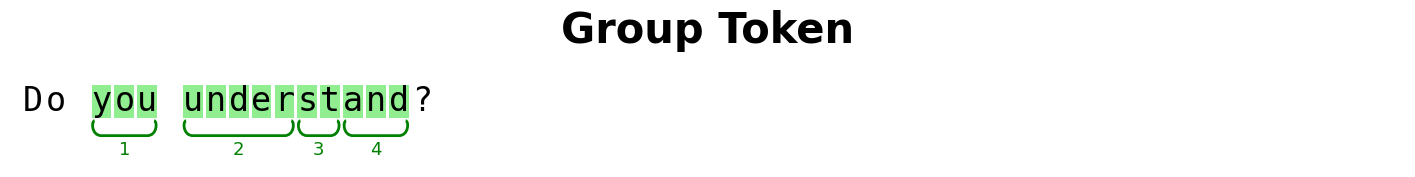

In [2]:
from magicab import Magicab

magicab = Magicab(model, 
                  tokenizer=tok, # input tokenizer
                  checkpoint_dir="checkpoint/base", spike_perplexity_threshold=5.0, group_perplexity_threshold=10.5)

magicab.group_quantile_threshold = 1.0

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]
texts = ["Do you understand?"]

# (a). Batch Visualizer
char_perplexity = magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [2]:
# Supervised-Fine-Tuning on GPT model 

# An example of SFT data 

# Apply Chat Template with ETokenizer
conv_data = [{"user": "hi"}]
tok.apply_chat_template(conv_data) # backward-crop for inference-time chat template application 

conv_data = [{"user": "hi"}, {"assistant": "hello"}]
tok.prepare_sft_data(conv_data) # sft data processing require context length handling and randomization

# Build SFT trainer (basically apply the loss_mask)

'<USER> hi<|endoftext|><ASSISTANT> hello<|endoftext|>'

In [ ]:
from data.alpaca.util import prepare_alpaca_data, get_batch

# Alpaca data preparation with tokenizer
prepare_alpaca_data(tok, block_size=512)

# Batch data loader with Alpaca 
input_ids, target_ids, loss_mask = get_batch(10, 'train', 'mps')